# Ordinance Violation Predictor for Buildings

## Description
This notebook provides a clustering algorithm for determining similar buildings based on a set of characteristics. The characteristics analyzed are as follows:
* Size (square footage)
* Location
* Age
* All the above combined for an aggregrate score

## Datasets
The data was obtained from Chicago's open data sets which includes the list of [building footprints](https://data.cityofchicago.org/Buildings/Building-Footprints-current-/hz9b-7nh8) along with [building ordinance violations](https://data.cityofchicago.org/Administration-Finance/Ordinance-Violations-Buildings-/awqx-tuwv).

Currently, the ordinance violations are cross referenced to the building footprints by their text addresses however this could be changed to use the geographic coordinates of the buildings instead.

## Purpose
The purpose of this notebook is to provide insight for determining possible ordinance violations for a specific building based on past ordinance violations of similar buildings.

# Data loading
The data is currently loaded from csv files download from the websites listed above which are also included alongside this notebook for ease of use. The ones in this repo may be out of date when you are reading this so updated CSV files should be obtained.

## Data Refinement
The data sets included have been refined via IBM Watson's data refinery so their columns may not include all the ones from the original dataset along with the address field being concatenated instead of split across multiple columns.

In [9]:
import sys
import types
import pip

import pandas as pd
import numpy as np
import time

df_buildings = pd.read_csv('buildings.csv_shaped.csv', low_memory=False)
df_buildings.head()

,Building ID,Building Status,Address,STORIES,BLDG_CREAT,BLDG_ACTIV,Building End Date,DEMOLISHED,X_COORD,Y_COORD,Z_COORD,NO_OF_UNIT,NO_STORIES,YEAR_BUILT,BLDG_SQ_FO,BLDG_CONDI,Area,SHAPE_LEN
0,886310,ACTIVE,7918 S GREENWOOD AVE,0,2008-12-31 08:00:00,2008-12-31 08:00:00,NaN,NaN,1.184841e+06,1.852609e+06,0.0,0,0,2007,0,SOUND,1634.989675,199.016806
1,886312,ACTIVE,1535 N DAYTON ST,0,2008-12-31 08:00:00,2008-12-31 08:00:00,NaN,NaN,1.170495e+06,1.910295e+06,0.0,0,0,0,0,NaN,30717.537943,744.827894
2,886311,ACTIVE,7914 S GREENWOOD AVE,0,2008-12-31 08:00:00,2008-12-31 08:00:00,NaN,NaN,1.184838e+06,1.852659e+06,0.0,0,0,2007,0,SOUND,1624.561811,198.088607
3,886313,ACTIVE,815 W WEED ST,0,2008-12-31 08:00:00,2008-12-31 08:00:00,NaN,NaN,1.170493e+06,1.910436e+06,0.0,0,0,0,0,NaN,4271.642427,322.068254
4,873246,ACTIVE,32 S THROOP PKWY,0,2007-12-31 08:00:00,2007-12-31 08:00:00,NaN,NaN,1.167600e+06,1.899840e+06,0.0,0,0,0,0,NaN,703.637823,113.295408


In [10]:
df_violations = pd.read_csv('Ordinance_Violations.csv', parse_dates={'Datetime':['VIOLATION DATE']})
df_violations.head()

,Datetime,ID,DOCKET NUMBER,NOV NUMBER,ADDRESS,STREET NUMBER,STREET DIRECTION,STREET NAME,STREET TYPE,WARD,...,CASE DISPOSITION,IMPOSED FINE,ADMIN COSTS,LAST MODIFIED DATE,VIOLATION CODE,VIOLATION DESCRIPTION,RESPONDENTS,LATITUDE,LONGITUDE,LOCATION
0,09/26/2012 09:00:00 AM,965ad2fd6e8f961798c5bacefb2e209752bd25ad,12BT04450A,12TO347680,3059 S ST LOUIS AVE,3059,S,ST LOUIS,AVE,22.0,...,Liable,1000.0,75,09/12/2013 10:15:31 AM,002011,"Submit plans prepared, signed, and sealed by a...",MARIA MATA | PEDRO MATA,41.837219,-87.712010,"(41.83721858678621, -87.71201003212285)"
1,09/17/2010 02:56:00 PM,aee0da696087cb466af545c91aed47b22ab06b60,10BS07350A,10SO272670,1647 W 78TH ST,1647,W,78TH,ST,17.0,...,Continuance,2500.0,0,06/13/2014 03:19:24 PM,070024,Repair or replace defective or missing members...,"PRODIGY DEVELOPMENT, LLC C/O JOHN BOLAND",41.752041,-87.665343,"(41.752040531792474, -87.66534297201679)"
2,04/29/2009 09:00:00 AM,0080068c9a238801e1b3c261abee7080b61a39d7,09BS06589A,09SO212941,2649 W 72ND ST,2649,W,72ND,ST,18.0,...,Not Liable,0.0,0,06/02/2010 09:33:03 AM,220029,Remove exposed wiring. (18-27-300.4),LAVEDA POWELL AKA LAVEDA R. GEORGE,41.762652,-87.690045,"(41.76265153244105, -87.69004496811375)"
3,11/07/2007 09:00:00 AM,ea5e070d934f04e4ae9c7c566210ad386a44a79c,08BN00099A,08F0148696,911 N HAMLIN AVE,911,N,HAMLIN,AVE,27.0,...,Liable,400.0,75,04/22/2008 08:44:35 AM,196029,"Post name, address, and telephone of owner, ow...",MARIA SZUPERNAK,41.897614,-87.721118,"(41.897613961137516, -87.72111756791027)"
4,08/11/2014 02:02:00 PM,3140adcc43c278b0cabad9e71bbba676df81de16,14BT05050A,14CO416005,2022 W 51ST ST,2022,W,51ST,ST,15.0,...,Liable,200.0,75,06/09/2015 11:22:44 AM,131026,Repair or replace defective screen. (13-196-56...,CELESTION SANCHEZ | MARIA SANCHEZ,41.801329,-87.675573,"(41.80132926401186, -87.6755727327648)"


## Joining the Datasets
Each data set is now joined based on their address fields. This may be unreliable since the two datasets are independent and may have slightly different syntax for some buildings.

This could be optimized by:
* Joining on geographic coordinates instead
* ~~Also, joining the ordinance violation dataset in once buildings are clustered~~
    * On second thought, it is more efficient to first join and narrow down the list of buildings to ones that only have violations recorded.

In [11]:
import datetime as dt

df_buildings['ADDRESS'] = df_buildings['Address']
df_violations['VIOLATION CODE'] = df_violations['VIOLATION CODE'].astype('category')

jdf = pd.merge(df_violations, df_buildings, how='inner', on='ADDRESS')
jdf = jdf[jdf['Datetime'] != 'nan']
jdf = jdf.sort_values('Datetime', ascending=False)

jdf.head()

,Datetime,ID,DOCKET NUMBER,NOV NUMBER,ADDRESS,STREET NUMBER,STREET DIRECTION,STREET NAME,STREET TYPE,WARD,...,X_COORD,Y_COORD,Z_COORD,NO_OF_UNIT,NO_STORIES,YEAR_BUILT,BLDG_SQ_FO,BLDG_CONDI,Area,SHAPE_LEN
179383,12/31/2017 11:00:00 AM,61019cab5dc5f2bb5b4a7ec181eee72c51a8ea4b,18BT00330A,18SH0546804,7037 S WABASH AVE,7037,S,WABASH,AVE,6.0,...,1.178042e+06,1.858230e+06,0.0,2,0,1914,2316,SOUND,1329.500,165.233409
179382,12/31/2017 11:00:00 AM,b874b97712b81612697004dc23b3531fd34f5fa6,18BT00330A,18SH0546804,7037 S WABASH AVE,7037,S,WABASH,AVE,6.0,...,1.178042e+06,1.858230e+06,0.0,2,0,1914,2316,SOUND,1329.500,165.233409
179381,12/31/2017 11:00:00 AM,1c63e34d21334eb0afd71f725e34801e8e7312bc,18BT00330A,18SH0546804,7037 S WABASH AVE,7037,S,WABASH,AVE,6.0,...,1.178042e+06,1.858230e+06,0.0,2,0,1914,2316,SOUND,1329.500,165.233409
403400,12/31/2017 09:53:00 AM,8f0857756ec58a9cb50ca0de129ea678a82f7bba,18BT00190A,18HS546236,7924 S HERMITAGE AVE,7924,S,HERMITAGE,AVE,17.0,...,1.165986e+06,1.852027e+06,0.0,2,0,1957,2234,SOUND,1158.375,158.146263
403399,12/31/2017 09:53:00 AM,055441618c84c10dce1fea4f5f42c8b90a5dc856,18BT00190A,18HS546236,7924 S HERMITAGE AVE,7924,S,HERMITAGE,AVE,17.0,...,1.165986e+06,1.852027e+06,0.0,2,0,1957,2234,SOUND,1158.375,158.146263


## Characteristic Definitions
Here we are defining multiple dataframes for each group representing their set of characteristics. There are three specific groups defined along with an aggregate of all group metrics:
* Location (`X_COORD`, `Y_COORD`)
* Size (`STORIES`, `NO_OF_UNIT`, `Area`)
* Age (`YEAR_BUILD`)

**Note:** The `X_COORD` and `Y_COORD` are not geographic coordinates but rather State Plane Coordinates which can be converted here http://www.earthpoint.us/StatePlane.aspx but an easy algorithm wasn't able to be found which could easily convert between the two.

In [15]:
def only_loc(frame):
    return frame[['X_COORD', 'Y_COORD']]

def only_size(frame):
    return frame[['STORIES', 'NO_OF_UNIT', 'Area']]

def only_age(frame):
    return frame[['YEAR_BUILT']]

def only_all(frame):
    return frame[['X_COORD', 'Y_COORD', 'STORIES', 'NO_OF_UNIT', 'Area', 'YEAR_BUILT']]

df_loc = only_loc(jdf)
df_size = only_size(jdf)
df_age = only_age(jdf)
df_all = only_all(jdf)

## Building to Reference for Similarities
Here we are using the [Salt Flats Innovation House](https://www.google.com/maps/place/Innovation+House/@41.8836379,-87.6552511,15z/data=!4m2!3m1!1s0x0:0xb8900b21391f68a3?ved=2ahUKEwjhg6z4zqneAhUM5bwKHQy4Db8Q_BIwF3oECAUQCw) as the building to obtain like buildings and relative ordinance violations.

The ID of that building was found to be `354999` so we just picked that building from the dataset and then reference it later when needed.

In [13]:
my_building = df_buildings.loc[df_buildings['Building ID'] == 354999]
my_building.head()

,Building ID,Building Status,Address,STORIES,BLDG_CREAT,BLDG_ACTIV,Building End Date,DEMOLISHED,X_COORD,Y_COORD,Z_COORD,NO_OF_UNIT,NO_STORIES,YEAR_BUILT,BLDG_SQ_FO,BLDG_CONDI,Area,SHAPE_LEN,ADDRESS
148239,354999,ACTIVE,113 N MAY ST,2,1998-04-01 08:00:00,1998-04-01 08:00:00,NaN,NaN,1.168895e+06,1.900927e+06,0.0,0,0,1930,32700,NEEDS MINOR REPAIR,16510.75,518.795811,113 N MAY ST


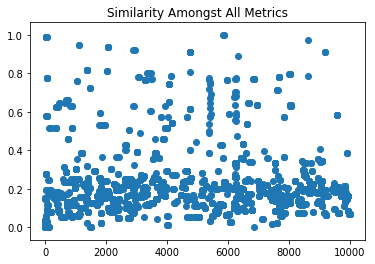

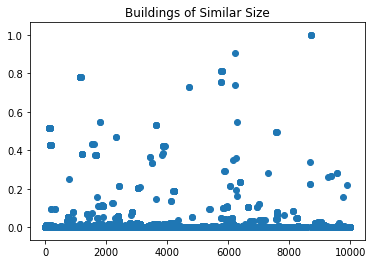

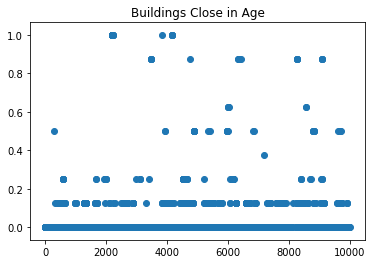

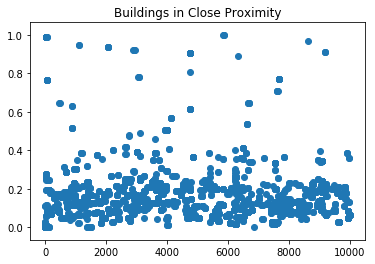

In [16]:
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Only plot the 75 most similar buildings
plt_limit = 75

def distance_matrix(frame, skip, take, one_to_match):
    df_limited = pd.concat([one_to_match, frame])[skip:take]
    dist_mat = squareform(pdist(df_limited, metric='euclidean'))

    distances = pd.DataFrame({'Distance': dist_mat[0,:]})
    distances = distances.sort_values('Distance')
    
    return distances[1:plt_limit]

batch_size = 10000
iterations = len(df_buildings) // batch_size

def close_distance_buildings(frame, building):
    distances = distance_matrix(frame, 0, batch_size, building)

    for i in range(1, iterations):
        similarity_plot = distance_matrix(frame, i * batch_size, i * batch_size + batch_size, building)
        distances = pd.concat([distances, similarity_plot])

    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(distances)
    
    # Here we normalize the distances for each characteristic so they can all be graphed with the same scale [0, 1]
    df_normalized = pd.DataFrame(x_scaled, index=distances.index, columns=['Distance'])

    plt.scatter(distances.index, df_normalized)
    plt.show()
    
    return df_normalized

plt.title('Similarity Amongst All Metrics')
dist_all = close_distance_buildings(df_all, only_all(my_building))

plt.title('Buildings of Similar Size')
dist_size = close_distance_buildings(df_size, only_size(my_building))

plt.title('Buildings Close in Age')
dist_age = close_distance_buildings(df_age, only_age(my_building))

plt.title('Buildings in Close Proximity')
dist_loc = close_distance_buildings(df_loc, only_loc(my_building))


## Clustering Algorithm
The method below performs the actual clustering algorithm using the Hierarchy clustering approach and a `k=3`.

The closest 2 sets of clusters are then saved to a CSV file, grouped and sorted by the most relevant columns.

Below, we also see that the closest two clusters are essentially split directly in half and the third cluster is very independent of the two.

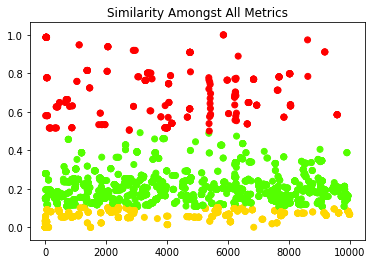

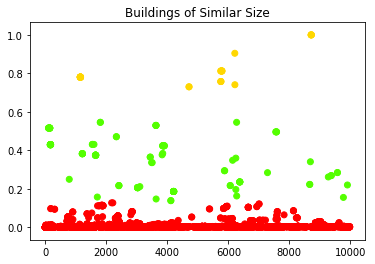

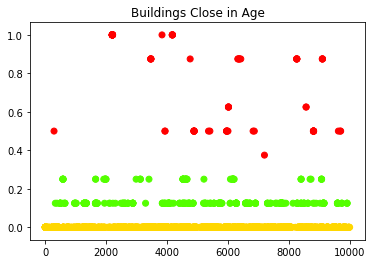

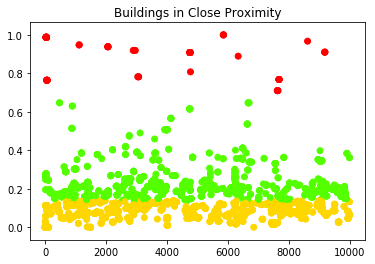

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import fcluster

def cluster_distances(distances, index):
    k = 3
    Z = linkage(distances, 'ward')
    c, coph_dists = cophenet(Z, pdist(distances))

    clusters = fcluster(Z, k, criterion='maxclust')
    plt.scatter(distances.index, distances['Distance'], c=clusters, cmap='prism')  # plot points with cluster dependent colors
    plt.show()

    distances['cluster'] = clusters
    joined = jdf.join(distances, how='inner')
    closest = joined.loc[joined['cluster'] <= 2]

    grouped_violations = closest \
        .groupby(['VIOLATION CODE', 'VIOLATION DESCRIPTION', 'IMPOSED FINE', 'ADDRESS', 'Datetime', 'Distance']) \
        .size().reset_index(name='counts')
    
    return grouped_violations
    
plt.title('Similarity Amongst All Metrics')
viol_all = cluster_distances(dist_all, 1)

plt.title('Buildings of Similar Size')
viol_size = cluster_distances(dist_size, 2)

plt.title('Buildings Close in Age')
viol_age = cluster_distances(dist_age, 3)

plt.title('Buildings in Close Proximity')
viol_loc = cluster_distances(dist_loc, 4)


In [19]:
dfs = [viol_all, viol_size, viol_age, viol_loc]
names = ['all', 'size', 'age', 'loc']

df = pd.concat(dfs, keys=names)
df = df.reset_index(level=1, drop=True).rename_axis('Distance Metric').reset_index()

df.sort_values(by=['counts', 'IMPOSED FINE'], ascending=False).to_csv('common_violations.csv')
